In [1]:
!pip install yfinance

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARMA
import seaborn

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1)- Get the dataset and perform some data analysis and visualization

In [26]:
# Get historical stock prices of Apple share over the last 10 years, indexed by date (YYYY-MM-DD).
aapl = yf.Ticker("AAPL")
df_apple = aapl.history(start="2009-06-07", end="2019-06-07", interval="1d")
df_apple.to_csv('aapl_days.csv')
df_apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-06-08,19.588889,19.644733,18.990954,19.592976,231534793,0.0,0.0
2009-06-09,19.587517,19.689670,19.143492,19.439054,168567063,0.0,0.0
2009-06-10,19.379122,19.388657,18.837028,19.102627,170596741,0.0,0.0
2009-06-11,19.007294,19.281064,18.871089,19.061775,130902205,0.0,0.0
2009-06-12,18.906496,18.945994,18.529209,18.655880,140047334,0.0,0.0


In [27]:
# Dataset shape
df_apple.shape

(2517, 7)

In [28]:
# Resample the dataset, to get stock prices per week.
df_week = df_apple.resample('w').mean()
df_week = df_week[['Close']]
df_week.head()

,Close
Date,
2009-06-14,19.170462
2009-06-21,18.615844
2009-06-28,18.793454
2009-07-05,19.315457
2009-07-12,18.690207


In [29]:
# Shape of the weekly dataset
df_week.shape

(522, 1)

In [30]:
# Let's compute the log of the first difference returns to normalize large fluctuations.
df_week['week_return'] = np.log(df_week['Close']).diff()
df_week.dropna(inplace=True)
df_week.head()

,Close,week_return
Date,,
2009-06-21,18.615844,-0.029358
2009-06-28,18.793454,0.009496
2009-07-05,19.315457,0.027397
2009-07-12,18.690207,-0.032906
2009-07-19,19.906513,0.063047


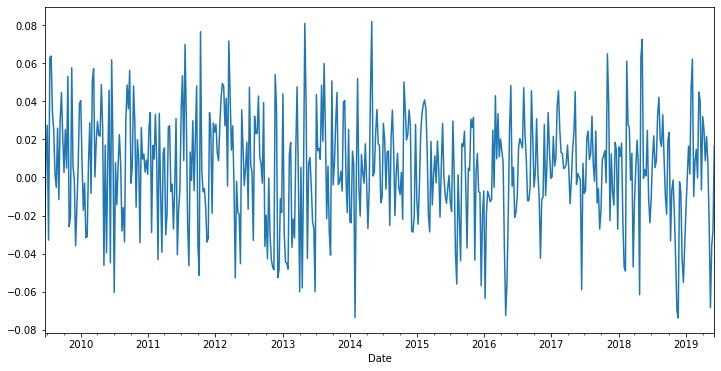

In [31]:
# Plotting the weekly return distribution
df_week['week_return'].plot(kind='line', figsize=(12, 6))

In [32]:
# Construct a variable where to store the log of the first difference time series
log_diff = df_week.drop(['Close'], axis=1)
log_diff.head()

,week_return
Date,
2009-06-21,-0.029358
2009-06-28,0.009496
2009-07-05,0.027397
2009-07-12,-0.032906
2009-07-19,0.063047


# 2)- Check the stationarity of the time series

A time series is stationary when the statistical measures like the mean and variance don't change over time. We usually have a stationary time series when it doesn't contain trends or seasonal swings.

In this part, we are using [The Augmented Dickey Fuller Test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to check the stationarity of the time series.

In [34]:
# First, let's compute the rolling mean & std using a window of size 20 weeks
rol_mean = log_diff.rolling(20).mean()
rol_std = log_diff.rolling(20).std()

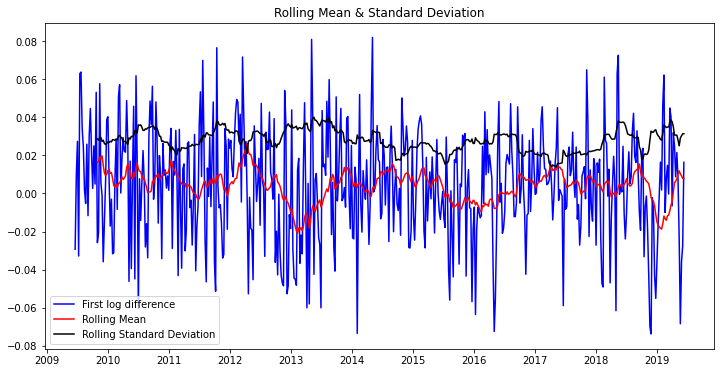

In [35]:
# Let's visualize how the mean & std are changing over time
plt.figure(figsize=(12, 6))
plt.plot(log_diff, color='blue', label='First log difference')
plt.plot(rol_mean, color='red', label='Rolling Mean')
plt.plot(rol_std, color='black', label = 'Rolling Standard Deviation')
plt.title('Rolling Mean & Standard Deviation')
plt.legend(loc='best')
plt.show()

In [36]:
# Performing The Augmented Dickey-Fuller test
adf_test = sm.tsa.adfuller(log_diff['week_return'], autolag='AIC')
df_output = pd.Series(adf_test[0:4], index=['ADF Statistic', 'p-value',
                                            'Nbr of lags used', 'Number of Observations Used'])
df_output

ADF Statistic                 -1.116934e+01
p-value                        2.664626e-20
Nbr of lags used               2.000000e+00
Number of Observations Used    5.180000e+02
dtype: float64

In our case, we can see that the $ pvalue < 0.05 $, so we can reject the null hypothesis (H0), and consider that our time series is stationary.

# 3)- Construct the ARIMA model

ARIMA is a model widely used in time series analysis, and in signal processing applications. It's a combination of an Autoregressive model $ AR(p) $, and a moving average model $ MA(q) $. The letter "I" in the middle refers to how many differences $ d $ we perform on the time series in case this one is not stationary.

- If we denote $ X(t) $ as a time series, an Autoregressive model $ AR(p) $ will estimate a time series in an instant t based on the previous p instants. It can be expressed by the following forumula, where $ \varepsilon(t) $ is a [white noise](https://en.wikipedia.org/wiki/White_noise):

$$
\boxed{AR(p): X(t)=\sum_{i=1}^{p} a_{i} X(t-i)+\varepsilon(t)}
$$

- A moving average model estimates a time series $ X(t) $ based on previous error terms, where error terms are just a difference between a $ MA(q) $ model values and the actual model values:

$$
\boxed{MA(q): X(t)=\mu + \varepsilon(t) + \sum_{i=1}^{q} b_{i}\varepsilon(t-i)}
$$

- An $ ARMA(p, q) $ model is a a combination of the two previous models:

$$
\boxed{ARMA(p, q): X(t)=\varepsilon(t) + \sum_{i=1}^{p} a_{i}X(t-i) + \sum_{j=1}^{q} b_{j}\varepsilon(t-j)}
$$


## 3.1)- Plot ACF & PACF charts to determine ARIMA parameters

In this section, we are going to plot the Autocorrelation and Partial Autocorrelation functions (ACF & PACF), in order to determine the parameters $ p $ and $ q $ of the ARIMA model. Since our time series is already stationary, the parameter $ d = 0$.

The following table gives an overview of how to determine $ p $ and $ q $ parameters from ACF and PACF charts:


<img src="img/read_acf_pacf.jpg" data-canonical-src="img/read_acf_pacf.jpg" width="300" height="150" />

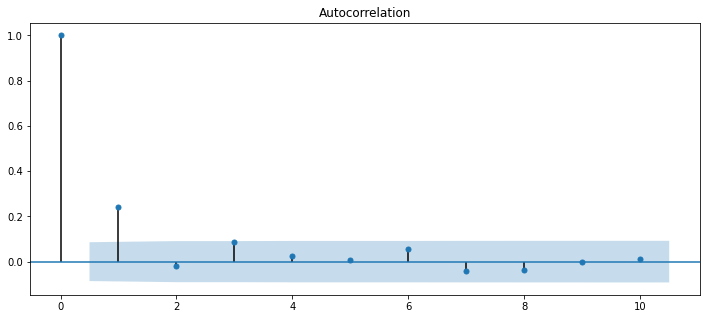

In [37]:
# Plot the ACF graph
fig, ax = plt.subplots(figsize=(12,5))
plot_acf(log_diff.values, lags=10, ax=ax)
plt.show()

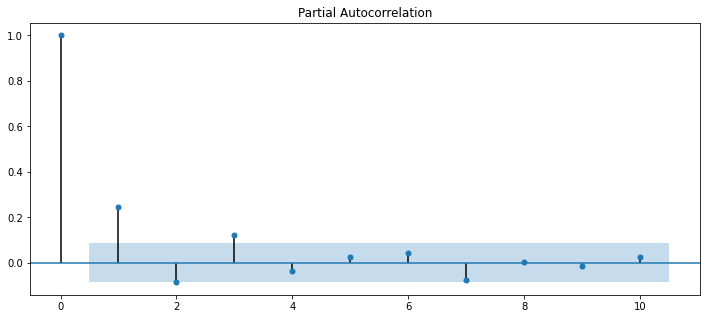

In [38]:
# Plot the PACF graph
fig, ax = plt.subplots(figsize=(12,5))
plot_pacf(log_diff.values, lags=10, ax=ax)
plt.show()

- From the PACF plot, we can see that the partial autocorrelation cuts off at lag 3, so $ p = 3 $.
- From the ACF plot, the autocorrelation cuts off at lag 1, so $ q = 1 $.
- To sum up, the ARIMA model to construct is the one having $ p = 3, d = 0 $, and $ q = 1 $. This model is equivalent to an ARMA model since the time series is already stationary.

## 3.2)- Train & test the ARIMA model

In [39]:
# Fit the model
p, q = 3, 1
arma = ARMA(tuple(log_diff.values), (p, q)).fit()
arma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  521
Model:                     ARMA(3, 1)   Log Likelihood                1128.851
Method:                       css-mle   S.D. of innovations              0.028
Date:                Sun, 12 Dec 2021   AIC                          -2245.701
Time:                        19:34:41   BIC                          -2220.167
Sample:                             0   HQIC                         -2235.699
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0043      0.002      2.599      0.010       0.001       0.007
ar.L1.y        0.0339      0.262      0.129      0.897      -0.480       0.548
ar.L2.y       -0.0545      0.083     -0.659      0.510      -0.217       0.108
ar.L3.y        0.0999      0.053      1.880      0.061      -0.004       0.204
ma.L1.y        0.2447      0.262      0.934      0.351      -0.269       0.758
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.8753           -1.8955j            2.0879           -0.3189
AR.2           -0.8753           +1.8955j            2.0879            0.3189
AR.3            2.2964           -0.0000j            2.2964           -0.0000
MA.1           -4.0864           +0.0000j            4.0864            0.5000
-----------------------------------------------------------------------------
"""

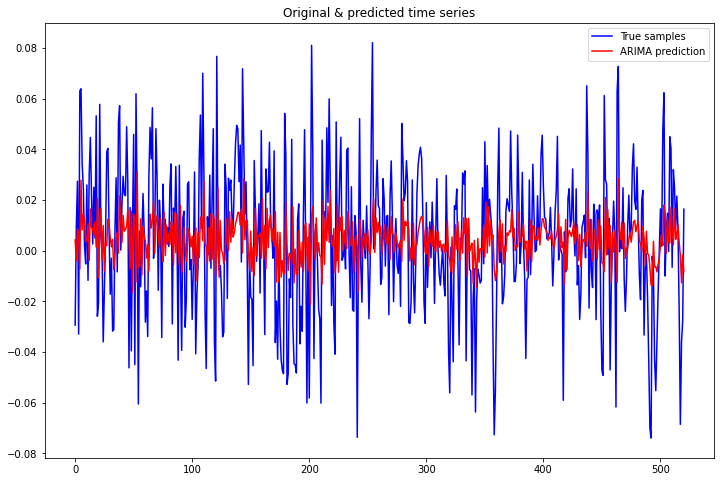

In [40]:
# Let's visualize the predicted time series and the ground truth over the training set
plt.figure(figsize=(12, 8))
plt.plot(log_diff.values, color='blue', label='True samples')
plt.plot(arma.fittedvalues, color='red', label='ARIMA prediction')
plt.title('Original & predicted time series')
plt.legend(loc='best')
plt.show()

We can see that our ARIMA model doesn't do a good job predicting variance in the original data (peaks and valleys).

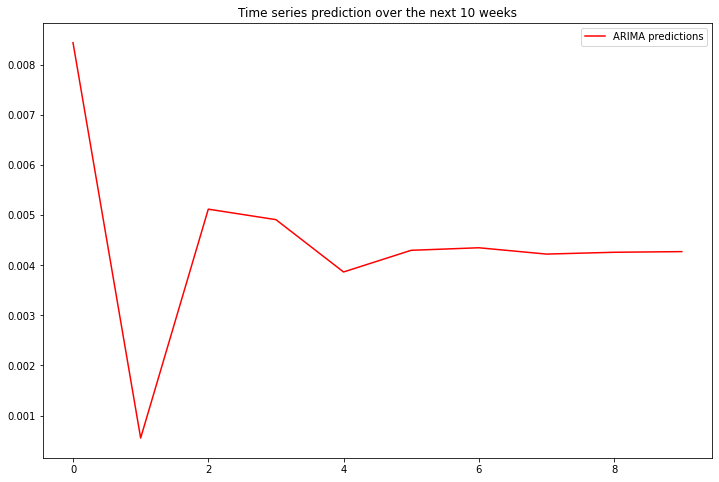

In [41]:
# Let's visulize ARIMA predictions over the next 10 weeks.
no_weeks = 10
test_pred = arma.forecast(steps=no_weeks)[0]

plt.figure(figsize=(12, 8))
plt.plot(test_pred, color='red', label='ARIMA predictions')
plt.title('Time series prediction over the next 10 weeks')
plt.legend(loc='best')
plt.show()

It seems like the model doesn't provide accurate predictions, since from the 6th week it converges to a constant value.